In [2]:
%load_ext autoreload
%autoreload 2


In [45]:
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from core.model_load_utils import load_model_transform, MODEL_LAYER_FILTERS, LAYER_ABBREVIATION_MAPS
from neural_regress.feature_reduction_lib import FEATURE_REDUCTION_DEFAULTS, LAYER_TRANSFORM_FILTERS
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_lib import sweep_regressors, transform_features2Xdict_new, transform_features2Xdict, RidgeCV, apply_feature_transforms
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit, format_result_df_tuple_index
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch
#%% Utility Functions
from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths

dataroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
data_path = join(dataroot, "red_20250428-20240429_vvs-encodingstimuli_z1_rw100-400.h5")
data = load_from_hdf5(data_path)
subject_id = "red_20250428-20240429"

encoding_stim_dir = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/encodingstimuli_apr2025"
data_dict = {}
data_dict['image_fps'] = parse_image_fullpaths(data['repavg']["stimulus_name"], [encoding_stim_dir], arbitrary_format=True)
data_dict['resp_mat'] = data['repavg']["response_peak"]
data_dict['resp_temp_mat'] = data['repavg']["response_temporal"]
data_dict['reliability'] = data['neuron_metadata']["reliability"]
data_dict['ncsnr'] = data['neuron_metadata']["ncsnr"]
data_dict['brain_area'] = data['neuron_metadata']["brain_area"]
data_dict['stim_pos'] = data['stimulus_meta']['xy_deg']
data_dict['stim_size'] = data["stimulus_meta"]["size_px"]

All stimulus files were found


In [17]:
model_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/"
subject_id = "red_20250428-20240429"
model_output_dir = join(model_root, subject_id, "model_outputs")

In [8]:
model_names = [
    "dinov2_vitb14_reg",
    "clipag_vitb32",
    "siglip2_vitb16",
    "radio_v2.5-b",
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
    # "ReAlnet01",
]

In [10]:
!ls {model_output_dir}/*.pkl

/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/red_20250428-20240429/model_outputs/red_20250428-20240429_AlexNet_training_seed_01_sweep_regressors_layers_pred_meta.pkl
/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/red_20250428-20240429/model_outputs/red_20250428-20240429_AlexNet_training_seed_01_sweep_regressors_layers_sweep_RidgeCV_df.pkl
/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/red_20250428-20240429/model_outputs/red_20250428-20240429_AlexNet_training_seed_01_sweep_regressors_layers_Xtfmer_RidgeCV.pkl
/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/red_20250428-20240429/model_outputs/red_20250428-20240429_clipag_vitb32_sweep_regressors_layers_pred_meta.pkl
/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/red_20250428-20240429/model_outputs/red_20250428-20240429_clipag_vitb32_sweep_regressors_layers_sweep_RidgeCV_df.pkl
/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/re

In [23]:
import os
import pickle as pkl
import pandas as pd

In [20]:
modelname = "dinov2_vitb14_reg"
model_names = [
    "dinov2_vitb14_reg",
    "clipag_vitb32",
    "siglip2_vitb16",
    "radio_v2.5-b",
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
    # "ReAlnet01",
]
for modelname in model_names:
    pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    assert os.path.exists(pred_meta_path)
    result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
    assert os.path.exists(result_df_path)
    pred_meta = pkl.load(open(pred_meta_path, "rb"))
    result_df = pd.read_pickle(result_df_path)

In [42]:
# modelname = "regnety_640"
modelname = "resnet50"
pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
assert os.path.exists(pred_meta_path)
result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
assert os.path.exists(result_df_path)
result_df = pd.read_pickle(result_df_path)
pred_meta = pkl.load(open(pred_meta_path, "rb"))
D2_per_unit_train_dict = pred_meta["D2_per_unit_train_dict"]
D2_per_unit_test_dict = pred_meta["D2_per_unit_test_dict"]
D2_per_unit_dict = pred_meta["D2_per_unit_dict"]
pred_dict = pred_meta["pred_dict"]

In [43]:
# Get indices of top 5 most reliable neurons
topk_reliable_chan_idx = np.argsort(data_dict['reliability'])[-5:][::-1]
topk_reliability = data_dict['reliability'][topk_reliable_chan_idx]
print(topk_reliability)
print(topk_reliable_chan_idx)


[0.8390227  0.82361527 0.80060784 0.78369492 0.77112247]
[15  9  0 19  2]


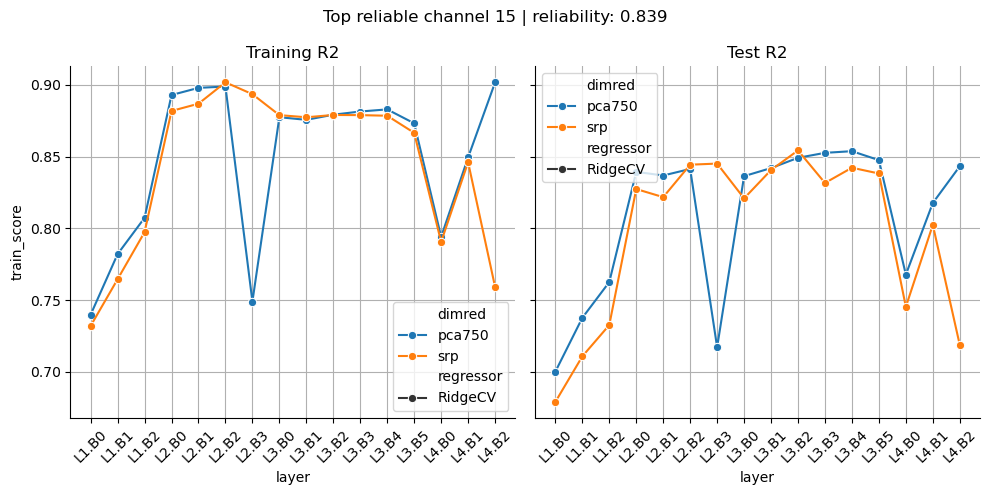

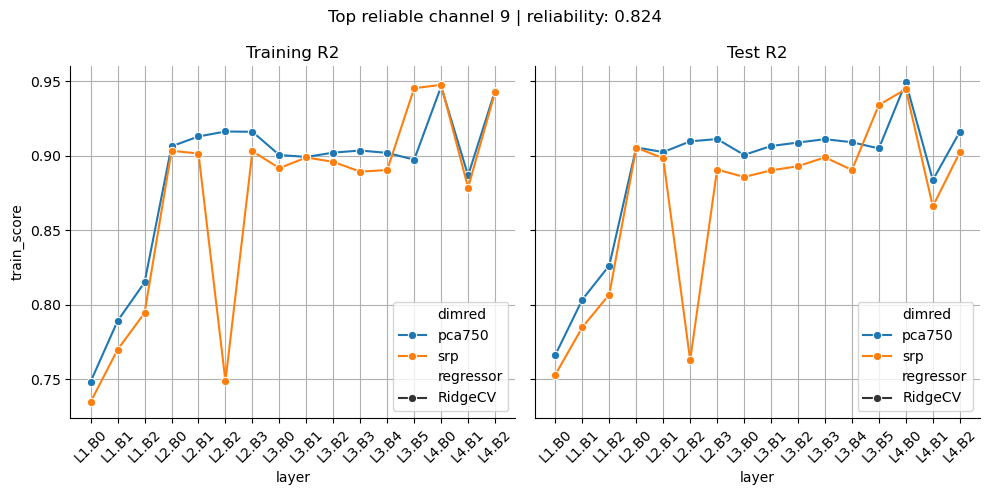

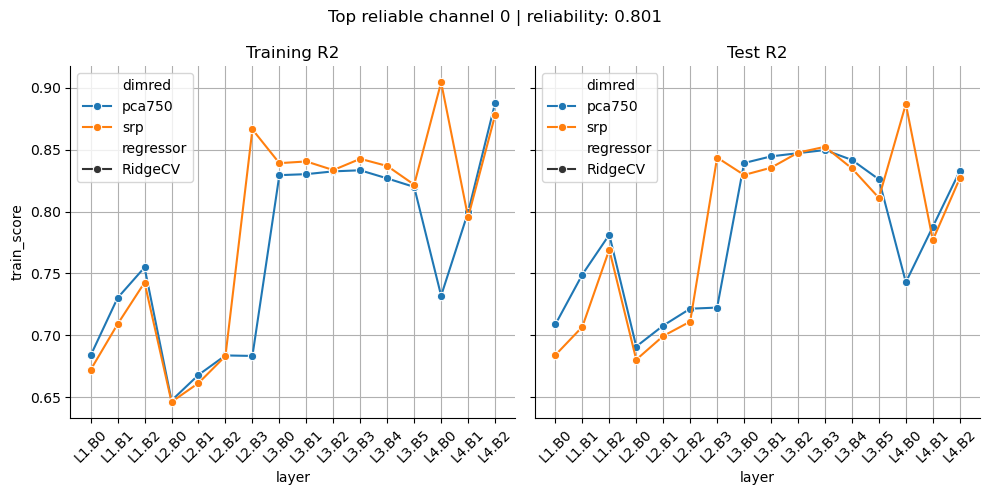

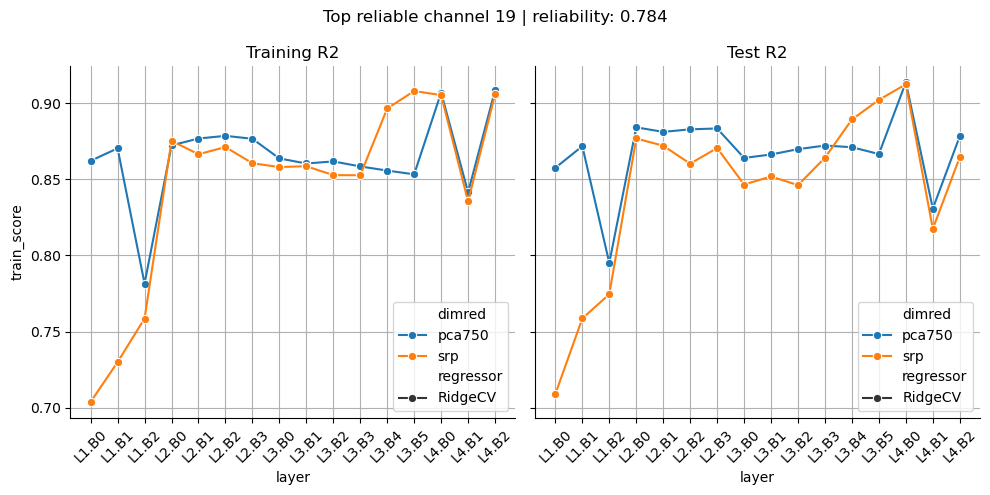

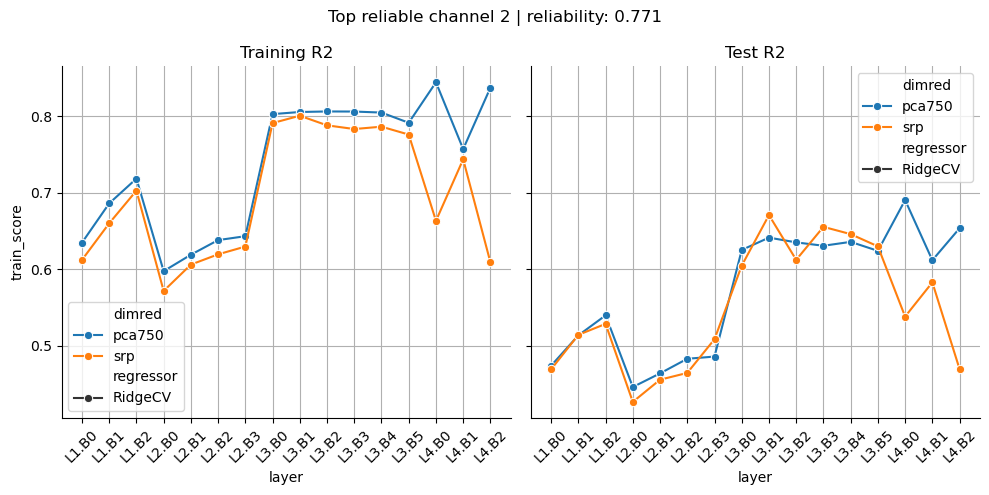

In [44]:
for idx in topk_reliable_chan_idx:
    single_chan_result_df = construct_result_df_masked(D2_per_unit_train_dict, D2_per_unit_test_dict, mask=idx)
    fig = plot_result_df_per_layer(single_chan_result_df, grid=True, sharey=True)
    fig.suptitle(f"{modelname} | Top reliable channel {idx} | reliability: {data_dict['reliability'][idx]:.3f}")
    plt.tight_layout()
    fig.show()
    # fig.savefig(f"single_chan_result_df_{idx}.png")

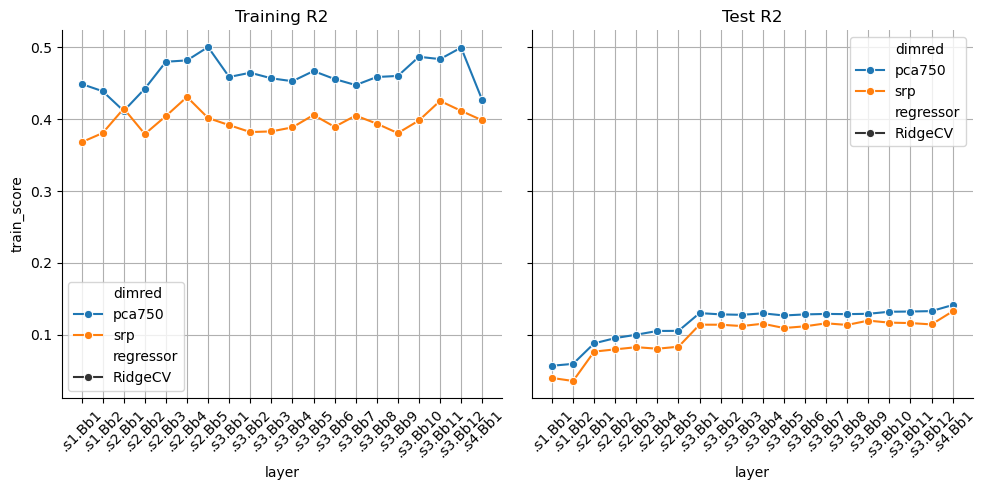

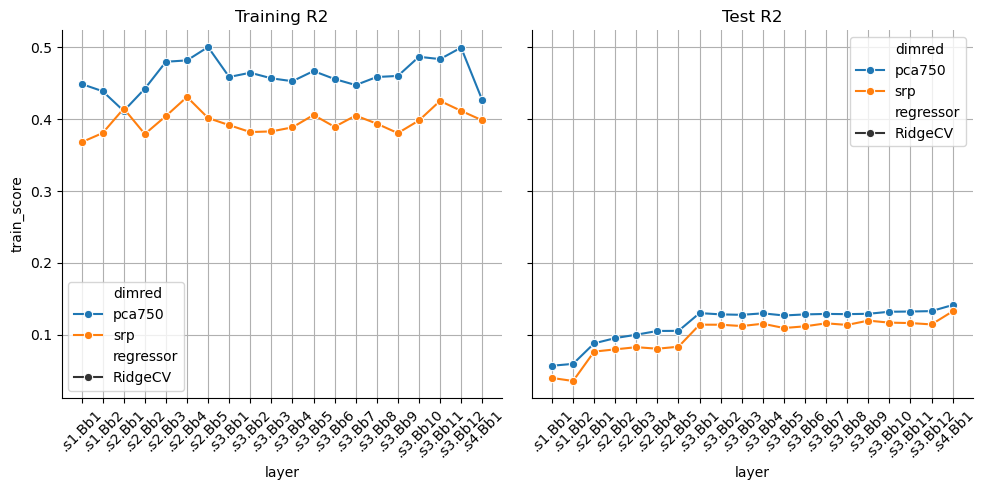

In [30]:
plot_result_df_per_layer(result_df, grid=True, sharey=True)

In [22]:
pred_meta["pred_dict"]

{(('.features.Conv2d0', 'pca750'),
  'RidgeCV'): array([[-0.28334053, -0.00425134, -0.26292879, ..., -0.12901817,
         -0.00246701, -0.13268874],
        [ 0.13393329, -0.00446812, -0.1737908 , ..., -0.10496321,
         -0.0022098 , -0.14542662],
        [ 0.23369471, -0.0041991 , -0.1604947 , ..., -0.02388006,
         -0.00238076, -0.26972577],
        ...,
        [ 0.83023768, -0.00427024, -0.09457462, ...,  0.06942611,
         -0.00223929, -0.43013529],
        [ 0.01427756, -0.00383929,  0.24967022, ...,  0.01064589,
         -0.00226492,  0.61982056],
        [ 0.62887059, -0.004301  , -0.07401879, ..., -0.01877954,
         -0.00234595, -0.45752243]]),
 (('.features.Conv2d0', 'srp'),
  'RidgeCV'): array([[-0.29675932, -0.00426338, -0.28093285, ..., -0.13848999,
         -0.00248688, -0.14811481],
        [ 0.1785793 , -0.00447853, -0.17832976, ..., -0.102765  ,
         -0.00221899, -0.15491154],
        [ 0.28714402, -0.00420144, -0.15224609, ..., -0.01475843,
         -

### Synopsis plot across the top channels

In [50]:
modelname = "dinov2_vitb14_reg"
model_names = [
    "dinov2_vitb14_reg",
    "clipag_vitb32",
    "siglip2_vitb16",
    "radio_v2.5-b",
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
    # "ReAlnet01",
]
reliability = data_dict['reliability']
top5_chan_result_df_col = []
for modelname in model_names:
    pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    assert os.path.exists(pred_meta_path)
    result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
    assert os.path.exists(result_df_path)
    pred_meta = pkl.load(open(pred_meta_path, "rb"))
    result_df = pd.read_pickle(result_df_path)
    D2_per_unit_train_dict = pred_meta["D2_per_unit_train_dict"]
    D2_per_unit_test_dict = pred_meta["D2_per_unit_test_dict"]
    top5_chan_result_df = construct_result_df_masked(D2_per_unit_train_dict, D2_per_unit_test_dict, mask=reliability > 0.7)
    top5_chan_result_df = format_result_df_tuple_index(top5_chan_result_df, )
    top5_chan_result_df["modelname"] = modelname
    top5_chan_result_df["layer_abbrev"] = top5_chan_result_df["layer"].map(LAYER_ABBREVIATION_MAPS[modelname])
    top5_chan_result_df_col.append(top5_chan_result_df)
top5_chan_result_df = pd.concat(top5_chan_result_df_col, axis=0)
# top5_chan_result_df.to_csv(join(model_output_dir, f"{subject_id}_top5_chan_result_df.csv"))




In [53]:
top5_chan_result_df

,layer,dimred,regressor,layer_dimred,train_score,test_score,modelname,layer_abbrev
0,.blocks.NestedTensorBlock0,cls_token,RidgeCV,.blocks.NestedTensorBlock0_cls_token,0.352932,0.357745,dinov2_vitb14_reg,B0
1,.blocks.NestedTensorBlock0,mean_register_token,RidgeCV,.blocks.NestedTensorBlock0_mean_register_token,0.438650,0.419926,dinov2_vitb14_reg,B0
2,.blocks.NestedTensorBlock0,maxpool_space_token,RidgeCV,.blocks.NestedTensorBlock0_maxpool_space_token,0.451107,0.470779,dinov2_vitb14_reg,B0
3,.blocks.NestedTensorBlock0,avgpool_space_token,RidgeCV,.blocks.NestedTensorBlock0_avgpool_space_token,0.388001,0.393340,dinov2_vitb14_reg,B0
4,.blocks.NestedTensorBlock0,cls_cat_maxpool_space_token,RidgeCV,.blocks.NestedTensorBlock0_cls_cat_maxpool_spa...,0.457031,0.474915,dinov2_vitb14_reg,B0
...,...,...,...,...,...,...,...,...
31,.classifier.Conv2d3,srp,RidgeCV,.classifier.Conv2d3_srp,0.587289,0.566469,AlexNet_training_seed_01,fc7
32,.classifier.ReLU4,pca750,RidgeCV,.classifier.ReLU4_pca750,0.506599,0.498931,AlexNet_training_seed_01,relu7
33,.classifier.ReLU4,srp,RidgeCV,.classifier.ReLU4_srp,0.506946,0.499417,AlexNet_training_seed_01,relu7
34,.classifier.Conv2d6,pca750,RidgeCV,.classifier.Conv2d6_pca750,0.447880,0.435687,AlexNet_training_seed_01,fc8


/tmp/ipykernel_782647/1808265271.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.groupby('modelname').apply(


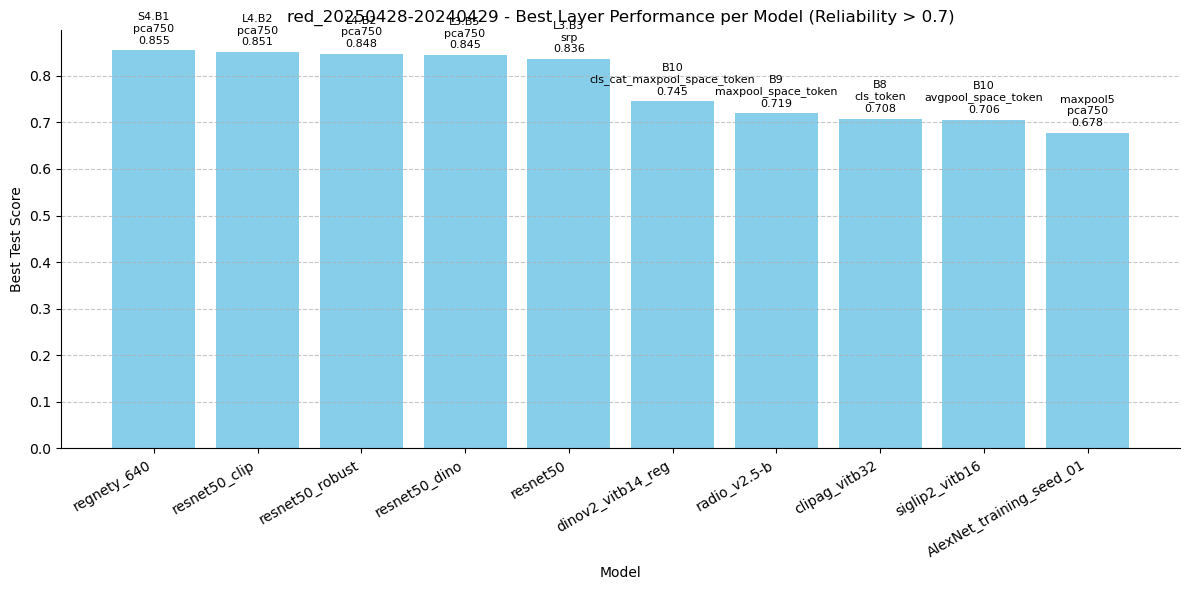

In [52]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)

# Sort by test_score for better visualization
best_per_model = best_per_model.sort_values('test_score', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(best_per_model['modelname'], best_per_model['test_score'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Best Test Score')
plt.title(f'{subject_id} - Best Layer Performance per Model (Reliability > 0.7)')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add the best layer/dimred info as text on top of each bar
for i, bar in enumerate(bars):
    layer = best_per_model.iloc[i]['layer_abbrev']
    dimred = best_per_model.iloc[i]['dimred']
    score = best_per_model.iloc[i]['test_score']
    
    # Truncate layer name if too long
    if len(layer) > 20:
        layer = layer[:17] + "..."
        
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 0.01, 
        f"{layer}\n{dimred}\n{score:.3f}", 
        ha='center', va='bottom', 
        fontsize=8, rotation=0
    )
plt.tight_layout()
plt.show()

### Model export to Thomas


In [100]:
import torch as th
import torch
from neural_regress.sklearn_torchify_lib import LinearLayer_from_sklearn, PCA_torch, SRP_torch
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
import os
from os.path import join
import numpy as np


In [78]:
model_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/"
subject_id = "red_20250428-20240429"
raw_model_output_dir = join(model_root, subject_id, "model_outputs")
exportdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
os.makedirs(exportdir, exist_ok=True)

In [79]:
resp_mat = data_dict['resp_mat']
ncsnr = data_dict['ncsnr']
reliability = data_dict["reliability"]
# save resp statistics 
mean_resp = resp_mat.mean(0)
std_resp = resp_mat.std(0)
q05_resp = np.percentile(resp_mat, 5, axis=0)
q95_resp = np.percentile(resp_mat, 95, axis=0)
min_resp = resp_mat.min(0)
max_resp = resp_mat.max(0)
resp_stats = {
    "resp_mat": resp_mat,
    "mean_resp": mean_resp,
    "std_resp": std_resp,
    "q05_resp": q05_resp,
    "q95_resp": q95_resp,
    "min_resp": min_resp,
    "max_resp": max_resp,
}
np.savez(join(exportdir, f"{subject_id}_resp_stats.npz"), **resp_stats)

In [80]:
# Get indices of top 5 most reliable neurons
topk_reliable_chan_idx = np.argsort(data_dict['reliability'])[-5:][::-1]
topk_reliability = data_dict['reliability'][topk_reliable_chan_idx]
print(topk_reliability)
print(topk_reliable_chan_idx)

[0.8390227  0.82361527 0.80060784 0.78369492 0.77112247]
[15  9  0 19  2]


In [81]:
topk_reliable_chan_idx

array([15,  9,  0, 19,  2])

In [102]:

modelname = "radio_v2.5-b"
# keys2export = [ 
#                ('.model.blocks.Block9_summary_token_flatten', 'RidgeCV')
#             ]
model_names = [
    "dinov2_vitb14_reg",
    "clipag_vitb32",
    "siglip2_vitb16",
    "radio_v2.5-b",
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
    # "ReAlnet01",
]
for modelname in [
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
]:
    Xtransform_path = join(raw_model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
    # red_20250428-20240429_resnet50_robust_sweep_regressors_layers_Xtfmer_RidgeCV.pkl
    readout_path = join(raw_model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
    meta_path = join(raw_model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    fit_models_lyrswp_RidgeCV = th.load(readout_path)
    # Xtfmer_lyrswp_RidgeCV = th.load(Xtransform_path)
    Xtfmer_lyrswp_RidgeCV = pkl.load(open(Xtransform_path, "rb"))
    pred_data = pkl.load(open(meta_path, "rb"))
    pred_dict = pred_data["pred_dict"]
    D2_per_unit_train_dict = pred_data["D2_per_unit_train_dict"]
    D2_per_unit_test_dict = pred_data["D2_per_unit_test_dict"]
    for unit_id in topk_reliable_chan_idx:
        single_chan_result_df = construct_result_df_masked(D2_per_unit_train_dict, D2_per_unit_test_dict, mask=unit_id)
        single_chan_result_df = format_result_df_tuple_index(single_chan_result_df, )
        # Filter out 'srp' dimension reduction and get the row with the best test score
        best_reg_row = single_chan_result_df.query("dimred != 'srp'").sort_values('test_score', ascending=False).iloc[0]
        print("Best config ")
        best_row = single_chan_result_df.query("dimred != 'srp'").sort_values('test_score', ascending=False).iloc[0]
        print(f"Best config - layer: {best_row['layer']}, dimred: {best_row['dimred']}, regressor: {best_row['regressor']}, "+\
              f"train_score: {best_row['train_score']:.3f}, test_score: {best_row['test_score']:.3f}")
        layername = best_row['layer']
        dimred_str = best_row['dimred']
        regressor_name = best_row['regressor']
        # raise Exception

        export_Xtransform_path = join(exportdir, f"{subject_id}_{modelname}_Ch{unit_id:02d}_Xtfmer_{layername}_{dimred_str}_{regressor_name}.pth")
        export_Xtransform_JIT_path = export_Xtransform_path.replace('.pth', '_JITscript.pt')
        export_meta_path = join(exportdir, f"{subject_id}_{modelname}_Ch{unit_id:02d}_meta_{layername}_{dimred_str}_{regressor_name}.pkl")
        export_readout_path = join(exportdir, f"{subject_id}_{modelname}_Ch{unit_id:02d}_readout_{layername}_{dimred_str}_{regressor_name}.pth")
        key = ((layername, dimred_str), regressor_name)
        
        regressor = fit_models_lyrswp_RidgeCV[key]
        Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
        pred_rsp = pred_data["pred_dict"][key]
        D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
        D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]
        readout = LinearLayer_from_sklearn(regressor)
        th.save(readout, export_readout_path)
        if isinstance(Xtfmer, PCA):
            Xtfmer = PCA_torch(Xtfmer)
        elif isinstance(Xtfmer, SparseRandomProjection):
            Xtfmer = SRP_torch(Xtfmer)
        th.save(Xtfmer, export_Xtransform_path)
        Xtfmer_script = torch.jit.script(Xtfmer)
        Xtfmer_script.save(export_Xtransform_JIT_path)
        th.save({
            "reliability": reliability,
            "ncsnr": ncsnr,
            "D2_per_unit_test": D2_per_unit_test,
            "D2_per_unit_train": D2_per_unit_train,
            **resp_stats
        }, export_meta_path)
        print(f"Saved {export_readout_path}")
        print(f"Saved {export_Xtransform_path}")
        print(f"JIT script saved to {export_Xtransform_JIT_path}")
        print(f"Saved {export_meta_path}")
        raise Exception

Best config 
Best config - layer: .layer4.Bottleneck2, dimred: pca750, regressor: RidgeCV, train_score: 0.896, test_score: 0.885
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_readout_.layer4.Bottleneck2_pca750_RidgeCV.pth
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV.pth
JIT script saved to /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV_JITscript.pt
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_meta_.layer4.Bottleneck2_pca750_RidgeCV.pkl


Exception: 

In [89]:
best_row = single_chan_result_df.query("dimred != 'srp'").sort_values('test_score', ascending=False).iloc[0]
print(f"Best config - layer: {best_row['layer']}, dimred: {best_row['dimred']}, regressor: {best_row['regressor']}, train_score: {best_row['train_score']:.3f}, test_score: {best_row['test_score']:.3f}")

Best config - layer: .layer4.Bottleneck2, dimred: pca750, regressor: RidgeCV, train_score: 0.896, test_score: 0.885


In [59]:
import yaml

In [75]:
template_path = "/n/home12/binxuwang/Github/Closed-loop-visual-insilico/notebooks/accentuation_template.yaml"
with open(template_path, "r") as f:
    content = f.read()

In [105]:
import datetime
template_path = "/n/home12/binxuwang/Github/Closed-loop-visual-insilico/notebooks/accentuation_template.yaml"
with open(template_path, "r") as f:
    content = f.read()
content = content.replace("{{subject_id}}", subject_id)
content = content.replace("{{model_name}}", modelname)
content = content.replace("{{unit_ids}}", str([unit_id]))
# Replace template variables with actual values
content = content.replace("{{fit_method_name}}", regressor_name)
content = content.replace("{{layer_name}}", layername)
# outputdir already replaced above
content = content.replace("{{outputdir}}", exportdir)
content = content.replace("{{readout_path}}", export_readout_path)
content = content.replace("{{xtransform_path}}", export_Xtransform_JIT_path)
content = content.replace("{{meta_path}}", export_meta_path)
content = content.replace("{{date}}", datetime.datetime.now().strftime("%d-%m-%Y"))
yaml.safe_load(content)

{'model_name': 'resnet50_robust',
 'fit_method_name': 'RidgeCV',
 'unit_ids': '[15]',
 'subject_id': 'red_20250428-20240429',
 'layer_name': '.layer4.Bottleneck2',
 'outputdir': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429',
 'readout_path': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_readout_.layer4.Bottleneck2_pca750_RidgeCV.pth',
 'xtransform_path': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV_JITscript.pt',
 'meta_path': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_meta_.layer4.Bottleneck2_pca750_RidgeCV.pkl',
 'result_folder': '/n/netscratch/kempner_fellows/Lab/tfel/prj_control/30-04-2025_resnet50_robust_accentu

In [114]:
def create_accentuation_config(
    subject_id, 
    modelname, 
    unit_id, 
    regressor_name, 
    layername, 
    exportdir, 
    export_readout_path, 
    export_Xtransform_JIT_path, 
    export_meta_path, 
    date=None,
    template_path=None, 
):
    """
    Create an accentuation configuration by filling in a template with specific values.
    
    Args:
        template_path: Path to the YAML template file
        subject_id: Subject ID for the experiment
        modelname: Name of the model
        unit_id: ID of the unit to process
        regressor_name: Name of the regression method
        layername: Name of the layer
        exportdir: Directory to export results
        export_readout_path: Path to the exported readout
        export_Xtransform_JIT_path: Path to the exported transform JIT script
        export_meta_path: Path to the exported metadata
        
    Returns:
        dict: Loaded YAML configuration
    """
    import datetime
    import yaml
    if template_path is None:
        template_path = "/n/home12/binxuwang/Github/Closed-loop-visual-insilico/notebooks/accentuation_template.yaml"
    with open(template_path, "r") as f:
        content = f.read()
    
    content = content.replace("{{subject_id}}", subject_id)
    content = content.replace("{{model_name}}", modelname)
    content = content.replace('"{{unit_ids}}"', str([unit_id]))
    content = content.replace("{{fit_method_name}}", regressor_name)
    content = content.replace("{{layer_name}}", layername)
    content = content.replace("{{outputdir}}", exportdir)
    content = content.replace("{{readout_path}}", export_readout_path)
    content = content.replace("{{xtransform_path}}", export_Xtransform_JIT_path)
    content = content.replace("{{meta_path}}", export_meta_path)
    if date is None:
        content = content.replace("{{date}}", datetime.datetime.now().strftime("%d-%m-%Y"))
    else:
        content = content.replace("{{date}}", date)
    
    return content, yaml.safe_load(content)


def save_and_verify_config(content, output_yaml_path, config=None):
    """
    Save the configuration to a file and verify it loads correctly.
    
    Args:
        content: YAML content as string
        config: Configuration dictionary
        exportdir: Directory to export the configuration
        subject_id: Subject ID for the experiment
        modelname: Name of the model
        unit_id: ID of the unit to process
        
    Returns:
        str: Path to the saved configuration file
    """
    with open(output_yaml_path, "w") as f:
        f.write(content)
    print(f"Configuration saved to {output_yaml_path}")
    
    # Verify that it loads correctly
    try:
        loaded_config = yaml.safe_load(open(output_yaml_path, "r"))
        print("Configuration loaded successfully")
        # check it's the same as config
        if config is not None:
            assert loaded_config == config, "Loaded configuration differs from original config"
            print("Loaded configuration matches the original config")
    except Exception as e:
        print(f"Error loading configuration: {e}")
    
    return output_yaml_path

# Example usage:
content, config = create_accentuation_config(
    subject_id=subject_id,
    modelname=modelname,
    unit_id=unit_id,
    regressor_name=regressor_name,
    layername=layername,
    exportdir=exportdir,
    export_readout_path=export_readout_path,
    export_Xtransform_JIT_path=export_Xtransform_JIT_path,
    export_meta_path=export_meta_path
)
output_yaml_path = f"{exportdir}/{subject_id}_{modelname}_Ch{unit_id}_accentuation_config.yaml"
save_and_verify_config(content, output_yaml_path, config)

Configuration saved to /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_accentuation_config.yaml
Configuration loaded successfully
Loaded configuration matches the original config


'/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_accentuation_config.yaml'

In [115]:
config

{'model_name': 'resnet50_robust',
 'fit_method_name': 'RidgeCV',
 'unit_ids': [15],
 'subject_id': 'red_20250428-20240429',
 'layer_name': '.layer4.Bottleneck2',
 'outputdir': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429',
 'readout_path': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_readout_.layer4.Bottleneck2_pca750_RidgeCV.pth',
 'xtransform_path': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_Xtfmer_.layer4.Bottleneck2_pca750_RidgeCV_JITscript.pt',
 'meta_path': '/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20250428-20240429/red_20250428-20240429_resnet50_robust_Ch15_meta_.layer4.Bottleneck2_pca750_RidgeCV.pkl',
 'result_folder': '/n/netscratch/kempner_fellows/Lab/tfel/prj_control/30-04-2025_resnet50_robust_accentuat

In [74]:
yaml.safe_load(content.replace('"{{unit_ids}}"', str([0])))

{'model_name': 'AlexNet_training_seed_01',
 'fit_method_name': '{{fit_method_name}}',
 'unit_ids': [0],
 'subject_id': '{{subject_id}}',
 'layer_name': '{{layer_name}}',
 'outputdir': '{{outputdir}}',
 'readout_path': '{{readout_path}}',
 'xtransform_path': '{{xtransform_path}}',
 'meta_path': '{{meta_path}}',
 'result_folder': '/n/netscratch/kempner_fellows/Lab/tfel/prj_control/{{date}}_AlexNet_training_seed_01_accentuation',
 'gifs_folder': '/n/netscratch/kempner_fellows/Lab/tfel/prj_control/{{date}}_AlexNet_training_seed_01_gifs',
 'log_dir': '/n/netscratch/kempner_fellows/Lab/tfel/prj_control/{{date}}_AlexNet_training_seed_01_logs',
 'seed_image_paths': ['shared1000/shared0631_nsd46161.png',
  'shared1000/shared0131_nsd11160.png',
  'shared1000/shared0196_nsd16467.png',
  'shared1000/shared0147_nsd12066.png',
  'shared1000/shared0491_nsd37225.png',
  'shared1000/shared0485_nsd36911.png',
  'shared1000/shared0862_nsd62480.png',
  'shared1000/shared0255_nsd21193.png',
  'shared1000/s

In [68]:
content

'model_name: "{{model_name}}"  \nfit_method_name: "{{fit_method_name}}"  \n\n# Units to process\nunit_ids: "{{unit_ids}}"\n\n# Model and data paths\nsubject_id: "{{subject_id}}"  \nlayer_name: "{{layer_name}}"  \noutputdir: "{{outputdir}}"\nreadout_path: "{{readout_path}}"\nxtransform_path: "{{xtransform_path}}"\nmeta_path: "{{meta_path}}"\n\n\n# Paths\nresult_folder: "/n/netscratch/kempner_fellows/Lab/tfel/prj_control/{{date}}_{{model_name}}_accentuation"\ngifs_folder: "/n/netscratch/kempner_fellows/Lab/tfel/prj_control/{{date}}_{{model_name}}_gifs"\nlog_dir: "/n/netscratch/kempner_fellows/Lab/tfel/prj_control/{{date}}_{{model_name}}_logs"\n\n\n# Input images\nseed_image_paths:\n  - "shared1000/shared0631_nsd46161.png"\n  - "shared1000/shared0131_nsd11160.png"\n  - "shared1000/shared0196_nsd16467.png"\n  - "shared1000/shared0147_nsd12066.png"\n  - "shared1000/shared0491_nsd37225.png"\n  - "shared1000/shared0485_nsd36911.png"\n  - "shared1000/shared0862_nsd62480.png"\n  - "shared1000/s

In [64]:
type(yaml.safe_load(open("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/notebooks/accentuation_template.yaml", "r")))

dict

In [ ]:
yaml.safe_load(open("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/notebooks/accentuation_template.yaml", "r"))